# 4) Balance risk types

This notebook balances the risk type breakdown (political, security and economic) of risk the risk headlines category in an attempt to improve the model's ability to identify underrepresented risk types. The results appear to show slightly improved accuracy when balancing risk types.


## Read-in data

Seperate dataframes are read-in for each language and dataset type. 

In [1]:
import pandas as pd
import numpy as np

# reads in the spanish improved label headlines
spanish_improved_labels_df = pd.read_csv('../Data/spanish_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_improved_labels_df)/1000, 1)) + 'K Spanish train headlines')

# reads in the spanish put aside headlines
spanish_put_aside_df = pd.read_csv('../Data/spanish_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_put_aside_df)/1000, 1)) + 'K Spanish put aside headlines')

# reads in the portuguese improved label headlines
portuguese_improved_labels_df = pd.read_csv('../Data/portuguese_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_improved_labels_df)/1000, 1)) + 'K Portuguese train headlines')

# reads in the portuguese put aside headlines
portuguese_put_aside_df = pd.read_csv('../Data/portuguese_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_put_aside_df)/1000, 1)) + 'K Portuguese put aside headlines')

24.2K Spanish train headlines
0.6K Spanish put aside headlines
6.6K Portuguese train headlines
0.6K Portuguese put aside headlines


## Balance risk types

### Risk type breakdown

The risk types are not evenly distributed in either dataset, potentially leading to underrepresented risk types.

In [7]:
# prints and returns a dataframe of risk type counts and percentages
def risk_type_breakdown(df, title):
    print()
    print('*** ' + title + ' ***')
    counts = round(df.risk_type.value_counts() / 1000, 2)
    percent = round(((counts*1000) / len(df)) * 100, 2)
    risk_type_df = pd.DataFrame({'k': counts, '%': percent})
    print(risk_type_df)
    return risk_type_df

spanish_risk_type_breakdown = risk_type_breakdown(spanish_improved_labels_df, 'Spanish')
portuguese_risk_type_breakdown = risk_type_breakdown(portuguese_improved_labels_df, 'Portuguese')


*** Spanish ***
                        k      %
risk_type                       
security_violence    4.34  17.94
political_stability  3.25  13.43
economic_regulatory  2.71  11.20

*** Portuguese ***
                        k      %
risk_type                       
political_stability  1.46  22.07
economic_regulatory  0.94  14.21
security_violence    0.84  12.70


### Sample risk types

To balance the risk types, an equal sample of each is taken using the length of the most underrepresented type as the sample size.

In [8]:
import random

# randomly samples an equal number of each risk type
def balance_risk_types(df, breakdown):
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    sample_no = int(min(breakdown.k) * 1000 - (len(df) * 0.01))
    
    risk_types = list(breakdown.index)
    sampled_headlines = []
    for risk in risk_types:
        population = list(df.loc[df.risk_type==risk].index)
        sample_indices = random.sample(population, sample_no)
        sampled_headlines.append(df.loc[df.index.isin(sample_indices)])
    
    return pd.concat([non_risk_df, pd.concat(sampled_headlines)]).reset_index(drop=True)

balanced_spanish_df = balance_risk_types(spanish_improved_labels_df, spanish_risk_type_breakdown)
balanced_portuguese_df = balance_risk_types(portuguese_improved_labels_df, portuguese_risk_type_breakdown)

## Evaluate performance

### Train test split

Creates a train test split for a given dataframe.

In [9]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.25):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

### Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# creates a confusion matrix heatmap
def heatmap(conf_matrix_df, colors):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_df, annot=True, cmap=colors, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# evaluates a model by printing the accuracy and classification report
def evaluate_model(model, X_test_tfidf, y_test, colors):
    # generates predictions
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
    print()
    
    # prints classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()
    
    # displays confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Risk', 'Actual Risk'], columns=['Pred Non-Risk', 'Pred Risk'])
    heatmap(conf_matrix_df, colors)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

### Fit & evaluate

A logistic regression model is trained and evaluated on TF-IDF vectors.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# evaluates a filtered dataset against new headlines
def fit_evaluate(train_df, put_aside_df, language, colors):
    # prints the language
    print()
    print('*** ' + language + ' ***')
    print()

    # instantiate vectorizer
    vectorizer = TfidfVectorizer()

    # prepare data
    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.001)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]

    # fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # evaluate data
    print(str(len(put_aside_df)) + ' put aside headlines')
    return evaluate_model(model, X_test_tfidf, y_test, colors)

### Unbalanced risk types

Evaluates the results of unbalanced headlines.


*** Spanish ***

600 put aside headlines
Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.25      0.39       300
           1       0.56      0.96      0.71       300

    accuracy                           0.60       600
   macro avg       0.71      0.60      0.55       600
weighted avg       0.71      0.60      0.55       600




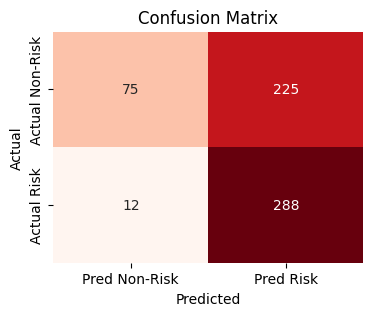



*** Portuguese ***

600 put aside headlines
Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.39      0.53       300
           1       0.60      0.92      0.73       300

    accuracy                           0.66       600
   macro avg       0.72      0.66      0.63       600
weighted avg       0.72      0.66      0.63       600




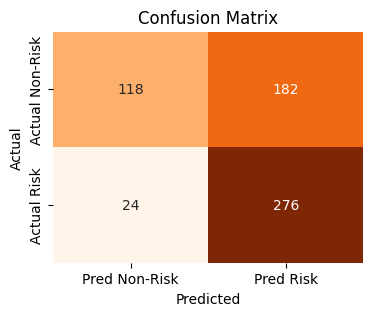

In [27]:
# trains and evaluates a model on the unbalanced headlines data
unbalanced_spanish_classification_report_ = fit_evaluate(spanish_improved_labels_df, spanish_put_aside_df, language='Spanish', colors='Reds')
unbalanced_portuguese_classification_report_ = fit_evaluate(portuguese_improved_labels_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

### Balanced risk types

Evaluates the results of balanced headlines.


*** Spanish ***

600 put aside headlines
Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.32      0.46       300
           1       0.58      0.94      0.72       300

    accuracy                           0.63       600
   macro avg       0.71      0.63      0.59       600
weighted avg       0.71      0.63      0.59       600




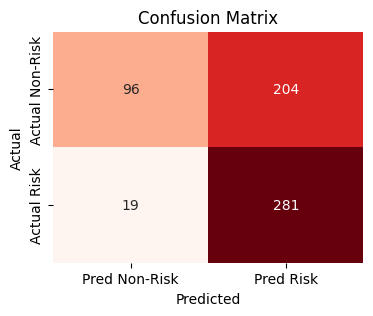



*** Portuguese ***

600 put aside headlines
Accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.49      0.60       300
           1       0.63      0.86      0.73       300

    accuracy                           0.68       600
   macro avg       0.71      0.68      0.66       600
weighted avg       0.71      0.68      0.66       600




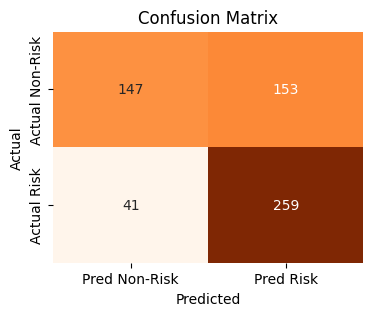

In [28]:
# trains and evaluates a model on the balanced headlines data
balanced_spanish_classification_report_ = fit_evaluate(balanced_spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
balanced_portuguese_classification_report_ = fit_evaluate(balanced_portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

## Visualize results

Overall accuracy doesn't seem to have improved for neither the Spanish nor Portuguese headlines.

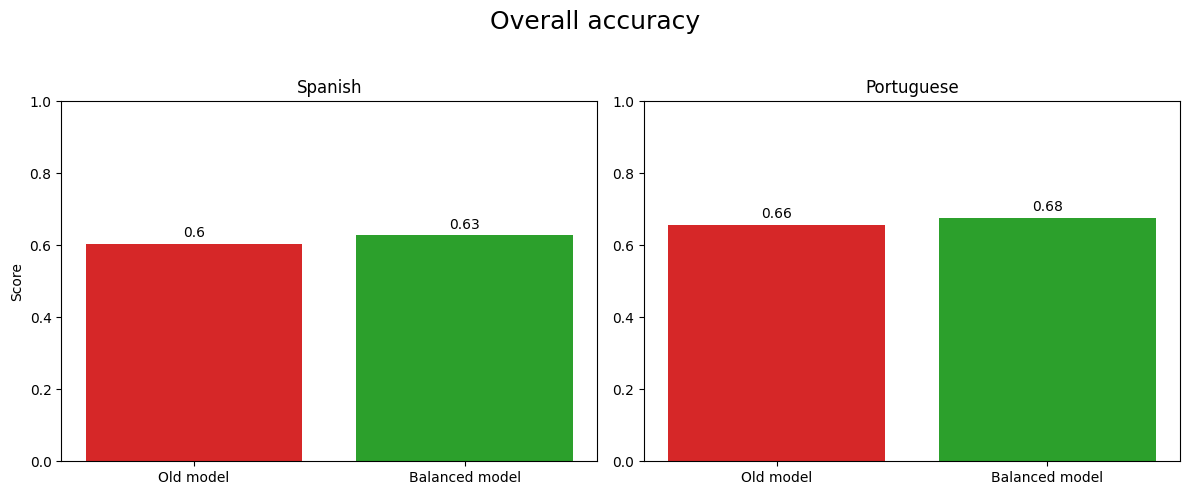

In [29]:
import matplotlib.pyplot as plt

# data
spanish_old_model = unbalanced_spanish_classification_report_['accuracy']
spanish_new_model = balanced_spanish_classification_report_['accuracy']
portuguese_old_model = unbalanced_portuguese_classification_report_['accuracy']
portuguese_new_model = balanced_portuguese_classification_report_['accuracy']

# labels for the statistics
labels = ['Spanish', 'Portuguese']
colors = ['tab:red', 'tab:green']

# data for the plots
old_model = [spanish_old_model, portuguese_old_model]
new_model = [spanish_new_model, portuguese_new_model]

# create subplots for comparison between languages and models
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot for Spanish
bars = axs[0].bar(['Old model', 'Balanced model'], [spanish_old_model, spanish_new_model], color=colors)
axs[0].set_title('Spanish')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot for Portuguese
bars = axs[1].bar(['Old model', 'Balanced model'], [portuguese_old_model, portuguese_new_model], color=colors)
axs[1].set_title('Portuguese')
axs[1].set_ylim(0, 1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title
fig.suptitle('Overall accuracy', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/balance_risk_types_overall_accuracy.png', dpi=600, bbox_inches='tight')

# show the plot
plt.show()